In [18]:
import  os

In [19]:
from dotenv import load_dotenv
load_dotenv()

True

In [20]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [21]:

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

In [22]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.prebuilt import create_react_agent


In [23]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--a9a89546-5b49-48c1-8b88-6b69f7529a1d-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [24]:
@tool
def contact_recipient_via_chat():
    """
    agents use this tool to contact to the recipe]ient via chat,, it aks for instuction fro the recipient
    Contacts the recipient via chat to provide updates or gather information. this will start a chat between the recipient and the delivery boy.
    """
    # Implementation for contacting the recipient via chat
    pass

@tool
def suggest_drop_off():
    """
    based on the chat between the recipient and the delivery boy,if the  user guves the permission then to use this toll thuis tool will be apecializeed in telling the alternative way for dropp off
    if the user uses this  tool then  the agent will suggest a drop-off location fot the delivery.
    """
    # Implementation for suggesting a drop-off location
    pass

@tool
def find_nearby_locker():
    """
    ifthe user finda none oif the safe drop-off thenn agent  will use this tool to suggest a secure parccel loacker as an alternative delivery poinnt
    
    Finds a nearby locker for the delivery.
    """
    # Implementation for finding a nearby locker
    pass


In [25]:
tools=[contact_recipient_via_chat, suggest_drop_off, find_nearby_locker]

In [26]:
llm_with_tools=llm.bind_tools(tools)

In [27]:
class State(MessagesState):
    next:str

In [28]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant who ensure that the delivery is done safely if the user is not present there.")
     

In [29]:
def grab_express(state: State) -> dict:
    """
    ReAct agent for handling express deliveries when the recipient is not present.
    Uses tools to contact the recipient, suggest drop-off locations, and find nearby lockers.
    it amaainly thinks whcih tool to use sequentialy
    
    """
    # Create a ReAct agent that can use our tools
    agent = create_react_agent(llm)
    result=agent.invoke(state["messages"])

    # Return the updated messages
    return {"messages": state["messages"] + [result]}

In [30]:
def grab_express_condition(state):
    # `state` is whatever your graph's state type is.
    # Return a string key to decide the path.
    if state.get("needs_contact"):
        return "contact"
    elif state.get("needs_drop_off"):
        return "suggest_drop_off"
    elif state.get("use_locker"):
        return "find_nearby_locker"
    else:
        return END   # fallback

In [31]:
graph = StateGraph(State)

In [32]:
# Add the grab_express node to the graph
graph.add_node("grab_express", grab_express)
graph.add_node("contact",contact_recipient_via_chat)
graph.add_node("suggest_drop_off", suggest_drop_off)
graph.add_node("find_nearby_locker", find_nearby_locker)

graph.add_edge(START, "grab_express")

graph.add_conditional_edges(
    "grab_express",
    grab_express_condition,
    {
        "contact": "contact",
        "suggest_drop_off": "suggest_drop_off",
        "find_nearby_locker": "find_nearby_locker",
        END: END
    }
)
graph.add_edge("contact", "grab_express")
graph.add_edge("suggest_drop_off", "grab_express")  
graph.add_edge("find_nearby_locker", "grab_express")
graph.add_edge("grab_express", END)
# Set the entry point

# Compile the graph
app = graph.compile()

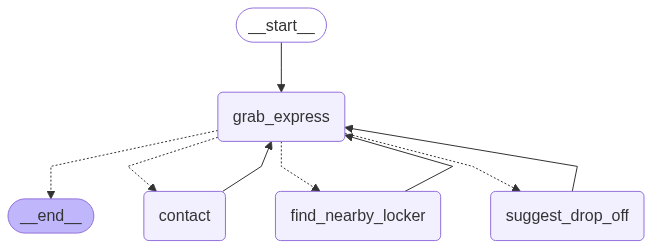

In [33]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
# Test example - uncomment to run
# inputs = {"messages": [HumanMessage(content="I'm trying to deliver a package but the recipient isn't home. What should I do?")]}
# result = app.invoke(inputs)
# print(result["messages"][-1].content)